In [220]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


# $$MONOETAPA$$

# MODELO: 2N5486 - NJFET

***
**VALORES DE HOJA DE DATOS**
- IDSS: [8,20]ma
- VP: [-2,-6]V
- rgs: 1M
- ro: inf

In [221]:
SALIDA_MIN = pd.read_csv("Simulaciones\Monoetapa\JFETN\JFETN-Salida-MIN.txt", sep='\t')
SALIDA_MAX = pd.read_csv("Simulaciones\Monoetapa\JFETN\JFETN-Salida-MAX.txt", sep='\t')
BODE_MONOETAPA_SIM = pd.read_csv("Simulaciones\Monoetapa\JFETN\BODE.txt", sep='\t')
#BODE = pd.read_csv("Mediciones\Monoetapa\NJFET.txt", sep='\t')
BODE_MONOETAPA_SIM

,Frecuencia,Ganancia,Fase
0,1.000000e+00,-16.284577,-43.859805
1,1.079775e+00,-15.294870,-45.750927
2,1.165914e+00,-14.324057,-47.604590
3,1.258925e+00,-13.370629,-49.412484
4,1.359356e+00,-12.432824,-51.168312
...,...,...,...
266,7.356423e+08,3.750781,61.696047
267,7.943282e+08,3.174493,57.605118
268,8.576959e+08,2.598437,53.422039
269,9.261187e+08,2.023513,49.146160


In [222]:
VDD=18
RS=470
RG1=820e3
RG2=100e3
IDSSMAX=20e-3
IDSSMIN=8e-3
IDSS=IDSSMIN
VPMAX=-6
VPMIN=-2
VP=VPMIN
RD=1e3
RL=10e3


# Calculo punto de polarizacion para el caso de transferencia minima

In [223]:
RG=RG1*RG2/(RG1+RG2)
VGG=VDD*RG2/(RG1+RG2)
a=(RS/VP)**2
b=( ((2*RS/VP)*(1-(VGG/VP)))-(1/IDSS) )
c=(1-(VGG/VP))**2
IDQ=(-b-np.sqrt(b**2 -4*a*c))/(2*a)
VGSQ=VP*(1-np.sqrt(IDQ/IDSS))
gm=(-2/VP)*np.sqrt(IDQ*IDSS)
AV=-gm*(RD*RL)/(RD+RL)
rgs=1e6
ri=(rgs*RG)/(RG+rgs)


In [224]:
parametrosJFET = pd.DataFrame(np.array([[VDD, 
                              RG1, 
                              RG2,
                              RS,
                              RD,
                              RL,
                              VGG,
                              RG,
                              IDQ,
                              VGSQ,
                              gm,
                              AV,
                              rgs,
                              ri]]),
                   columns=['VDD',
                            'RG1', 
                            'RG2',
                            'RS',
                            'RD',
                            'RL',
                            'VGG',
                            'RG',
                            'IDQ',
                            'VGSQ',
                            'gm',
                            'AV',
                            'rig',
                            'ri'])
parametrosJFET

,VDD,RG1,RG2,RS,RD,RL,VGG,RG,IDQ,VGSQ,gm,AV,rig,ri
0,18.0,820000.0,100000.0,470.0,1000.0,10000.0,1.956522,89130.434783,0.00504,-0.412481,0.00635,-5.772796,1000000.0,81836.327345


**Curva de entrada**


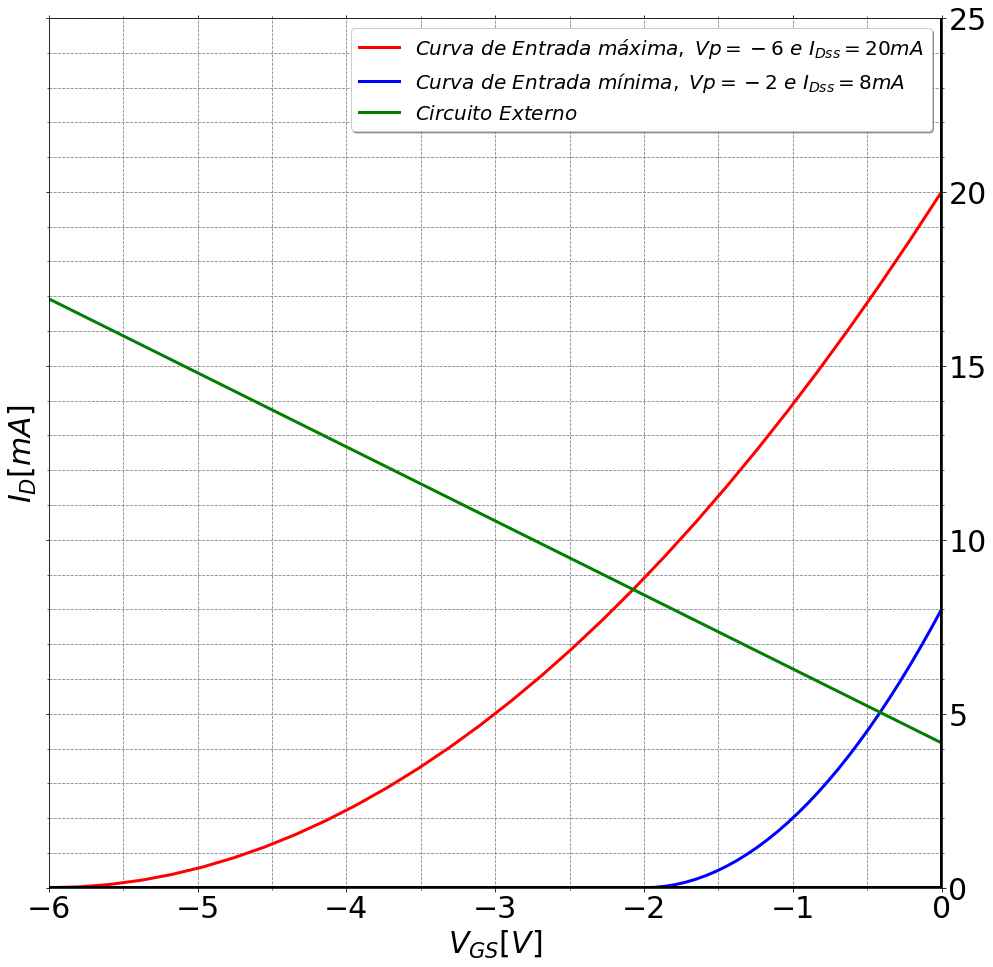

In [225]:
fig = plt.figure(figsize=[16, 16])
ax = fig.gca()
#Aca establezco la subdivicion del grafico
ax.set_xticks(np.linspace(-6, 0, 13), minor=True)
ax.set_yticks(np.linspace(-5,25, 31), minor=True)

ax.tick_params(axis='both', labelsize=30)

#Parametros en los cuatro lados
plt.tick_params(axis='both', labelsize=30, labelleft=False, labelright=True, labeltop=False, labelbottom=True)


#1000*EJERCICIO_A_1_A['time'] es para poner la escala en mili segundos

#SEÑAL DE ENTRADA Vi
vgsMax=np.linspace(-6, 0, 30)
vgsMin=np.linspace(-2, 0, 30)

plt.plot(vgsMax, 20*(1-vgsMax/(-6))**2,linewidth=3.0,c='r',label='$Curva\ de\ Entrada\ máxima,\ Vp=-6\ e\ I_{Dss}=20mA$')
plt.plot(vgsMin, 8*(1-vgsMin/(-2))**2,linewidth=3.0,c='b',label='$Curva\ de\ Entrada\ mínima,\ Vp=-2\ e\ I_{Dss}=8mA$')


vgsRecta=np.linspace(-6, 0, 20)
plt.plot(vgsRecta, ((VGG-vgsRecta)/RS)*1000,linewidth=3.0,c='g',label='$Circuito\ Externo$')


#EJE HORIZONTAL
ax.axhline(0,linestyle='-',linewidth=4,c='black')
ax.axvline(0,linestyle='-',linewidth=5,c='black')

#Limites del grafico
plt.xlim(-6, 0)
plt.ylim(0, 25)

#Nombre de los ejes
plt.xlabel('$V_{GS}[V]$', fontsize=30)
plt.ylabel('$I_D[mA]$', fontsize=30)

#Parametros del recuadro con nombre de las curvas y tamaño de la fuente
plt.legend(fontsize=20, shadow=True)

plt.grid(which='both',color='grey', linestyle='--')
plt.savefig('Imagenes\Monoetapa\JFETN\CurvaEntrada.png',bbox_inches='tight')


**Curva de Salida**


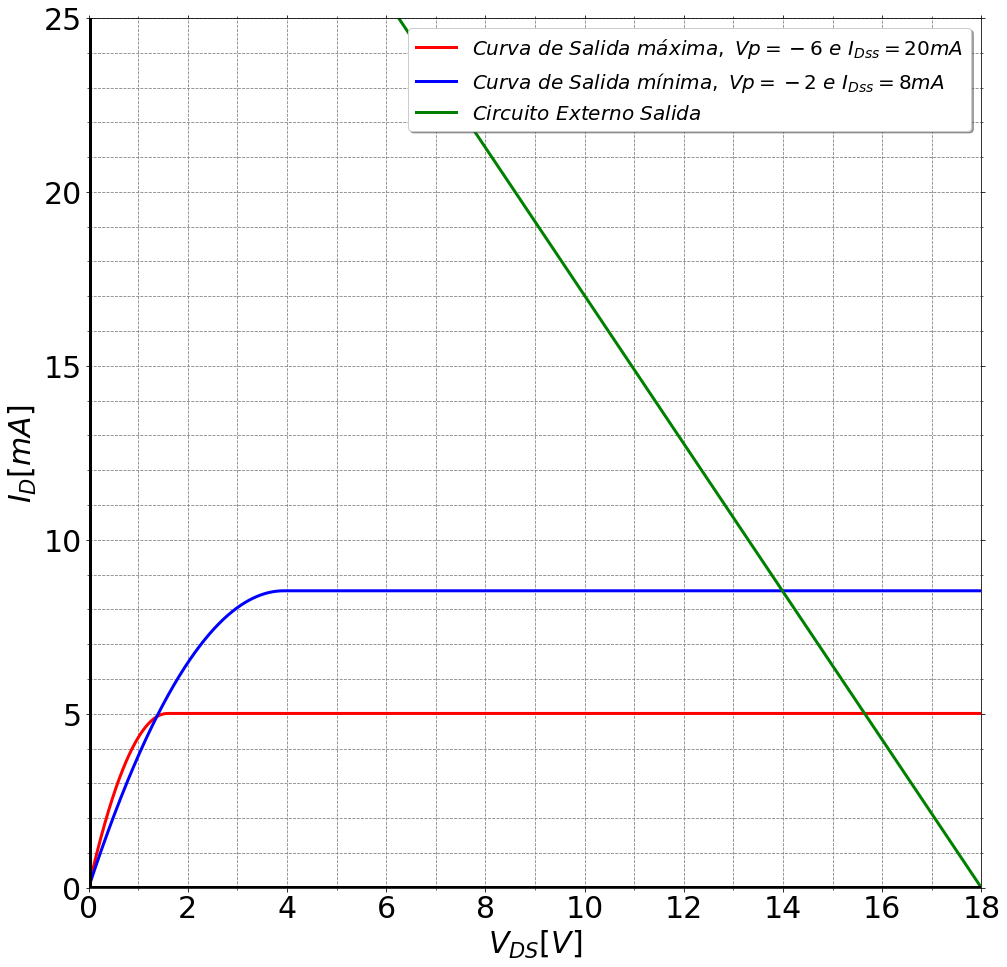

In [226]:
fig = plt.figure(figsize=[16, 16])
ax = fig.gca()
#Aca establezco la subdivicion del grafico
ax.set_xticks(np.linspace(0, 18, 19), minor=True)
ax.set_yticks(np.linspace(-5,25, 31), minor=True)

ax.tick_params(axis='both', labelsize=30)

#Parametros en los cuatro lados

plt.tick_params(axis='both', labelsize=30, labelleft=True, labelright=False, labeltop=False, labelbottom=True)




#SALIDA
vgsMax=np.linspace(-6, 0, 30)
vgsMin=np.linspace(-2, 0, 30)

plt.plot(SALIDA_MIN['VDS'], SALIDA_MIN['ID']*1000,linewidth=3.0,c='r',label='$Curva\ de\ Salida\ máxima,\ Vp=-6\ e\ I_{Dss}=20mA$')
plt.plot(SALIDA_MAX['VDS'], SALIDA_MAX['ID']*1000,linewidth=3.0,c='b',label='$Curva\ de\ Salida\ mínima,\ Vp=-2\ e\ I_{Dss}=8mA$')


vdsRecta=np.linspace(0,18, 20)

plt.plot(vdsRecta, (-vdsRecta/RS + VDD/RS)*1000,linewidth=3.0,c='g',label='$Circuito\ Externo\ Salida$')


#EJE HORIZONTAL
ax.axhline(0,linestyle='-',linewidth=4,c='black')
ax.axvline(0,linestyle='-',linewidth=6,c='black')

#Limites del grafico
plt.xlim(0, 18)
plt.ylim(-0, 25)

#Nombre de los ejes
plt.xlabel('$V_{DS}[V]$', fontsize=30)
plt.ylabel('$I_D[mA]$', fontsize=30)

#Parametros del recuadro con nombre de las curvas y tamaño de la fuente
plt.legend(fontsize=20, shadow=True,loc=1)

plt.grid(which='both',color='grey', linestyle='--')
plt.savefig('Imagenes\Monoetapa\JFETN\CurvaSalida.png',bbox_inches='tight')


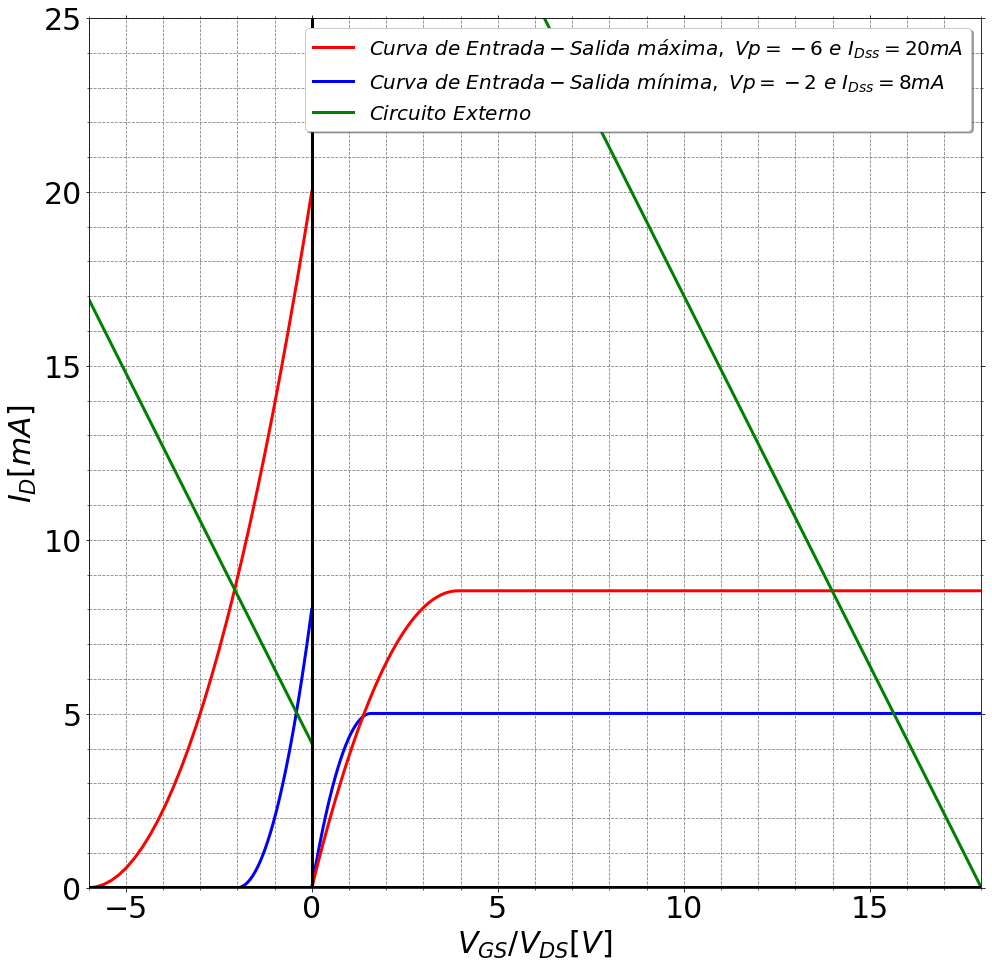

In [227]:
fig = plt.figure(figsize=[16, 16])
ax = fig.gca()
#Aca establezco la subdivicion del grafico
ax.set_xticks(np.linspace(-10, 20, 31), minor=True)
ax.set_yticks(np.linspace(-5,25, 31), minor=True)

ax.tick_params(axis='both', labelsize=30)

#Parametros en los cuatro lados

plt.tick_params(axis='both', labelsize=30, labelleft=True, labelright=False, labeltop=False, labelbottom=True)


#ENTRADA

vgsMax=np.linspace(-6, 0, 30)
vgsMin=np.linspace(-2, 0, 30)

plt.plot(vgsMax, 20*(1-vgsMax/(-6))**2,linewidth=3.0,c='r')
plt.plot(vgsMin, 8*(1-vgsMin/(-2))**2,linewidth=3.0,c='b')



vgsRecta=np.linspace(-6, 0, 20)
plt.plot(vgsRecta, ((VGG-vgsRecta)/RS)*1000,linewidth=3.0,c='g')
plt.plot(vgsRecta*1000, vgsRecta*1000 +40,linewidth=3.0,c='r',label='$Curva\ de\ Entrada-Salida\ máxima,\ Vp=-6\ e\ I_{Dss}=20mA$')
plt.plot(vgsRecta*1000, vgsRecta*1000 +40,linewidth=3.0,c='b',label='$Curva\ de\ Entrada-Salida\ mínima,\ Vp=-2\ e\ I_{Dss}=8mA$')
plt.plot(vgsRecta*1000, vgsRecta*1000 +40,linewidth=3.0,c='g',label='$Circuito\ Externo$')



#SALIDA
vgsMax=np.linspace(-6, 0, 30)
vgsMin=np.linspace(-2, 0, 30)

plt.plot(SALIDA_MIN['VDS'], SALIDA_MIN['ID']*1000,linewidth=3.0,c='b')
plt.plot(SALIDA_MAX['VDS'], SALIDA_MAX['ID']*1000,linewidth=3.0,c='r')


vdsRecta=np.linspace(0,18, 20)

plt.plot(vdsRecta, (-vdsRecta/RS + VDD/RS)*1000,linewidth=3.0,c='g')


#EJE HORIZONTAL
ax.axhline(0,linestyle='-',linewidth=4,c='black')
ax.axvline(0,linestyle='-',linewidth=3,c='black')

#Limites del grafico
plt.xlim(-6, 18)
plt.ylim(-0, 25)

#Nombre de los ejes
plt.xlabel('$V_{GS}/V_{DS}[V]$', fontsize=30)
plt.ylabel('$I_D[mA]$', fontsize=30)

#Parametros del recuadro con nombre de las curvas y tamaño de la fuente
plt.legend(fontsize=20, shadow=True,loc=1)

plt.grid(which='both',color='grey', linestyle='--')
plt.savefig('Imagenes\Monoetapa\JFETN\CurvaEntradaSalida.png',bbox_inches='tight')


**BODE**

In [274]:
BODE_MONOETAPA_MED=pd.read_csv(r"Mediciones\Monoetapa\NJFET\JFETN.txt", sep='\t')


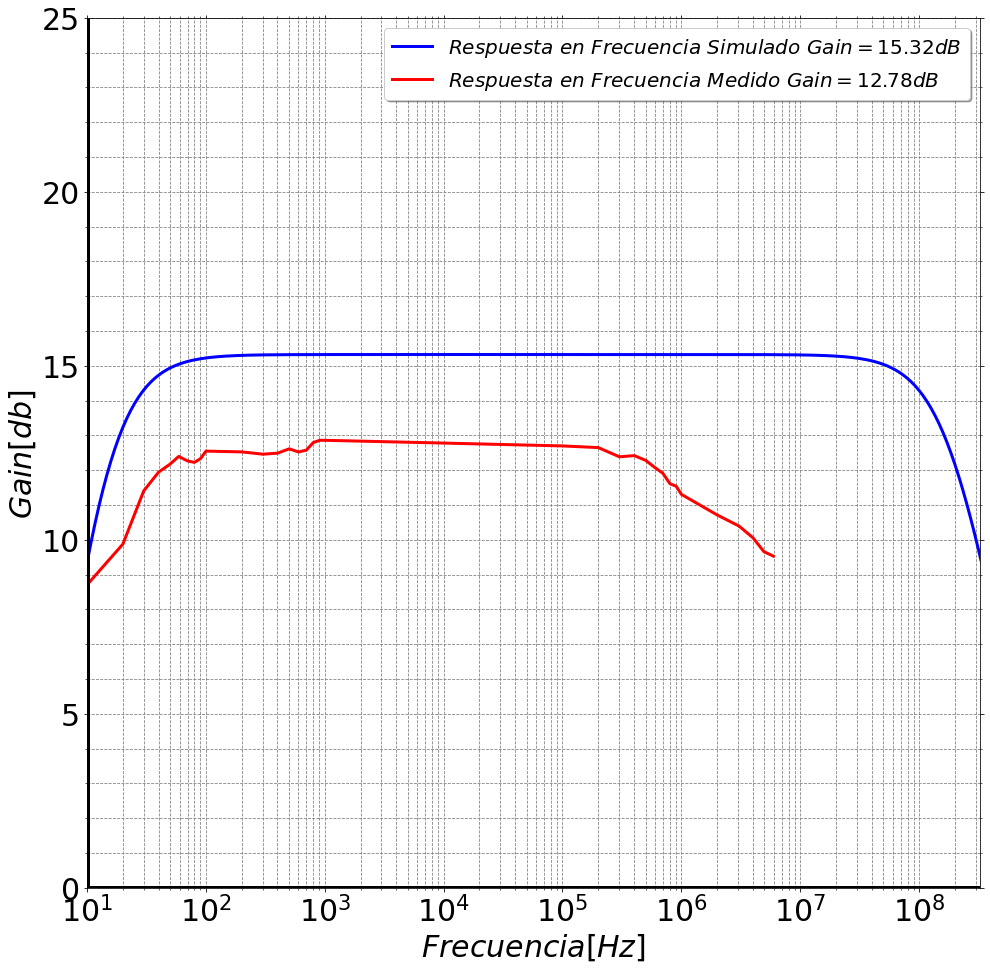

In [275]:
fig = plt.figure(figsize=[16, 16])
ax = fig.add_subplot(1,1,1)

ax.tick_params(axis='both', labelsize=30, labelleft=True, labelright=False, labeltop=False, labelbottom=True)

ax.set_yticks(np.linspace(0, 25, 26), minor=True)



ax.plot(BODE_MONOETAPA_SIM['Frecuencia'], BODE_MONOETAPA_SIM['Ganancia'],linewidth=3.0,c='b',label='$Respuesta\ en\ Frecuencia\ Simulado\ Gain=15.32dB$')
ax.plot(BODE_MONOETAPA_MED['Frecuencia'], 20*np.log10(BODE_MONOETAPA_MED['Vo']/BODE_MONOETAPA_MED['Vi']),linewidth=3.0,c='r',label='$Respuesta\ en\ Frecuencia\ Medido\ Gain=12.78dB$')

ax.axhline(0,linestyle='-',linewidth=4,c='black')
ax.axvline(10,linestyle='-',linewidth=5,c='black')

#ax.plot(frecuencia, ganacia)
ax.set_xlabel('$Frecuencia[Hz]$', fontsize=30)
ax.set_ylabel('$Gain[db]$', fontsize=30)

# ax.plot(frecuencia, ganacia)
ax.set_xticks(np.linspace(-0.75, -0.15, 25), minor=True)

plt.xlim(10,3.25e8)
plt.ylim(0, 25)
ax.set_xscale('log')
plt.grid(which='both',color='grey', linestyle='--')
plt.legend(fontsize=20, shadow=True,loc=1)
plt.savefig('Imagenes\Monoetapa\JFETN\BODE.png',bbox_inches='tight')


# MODELO: BC548B - NTBJ

***
**VALORES DE HOJA DE DATOS**
- Beta: [200,450] Tipico 290
- VBE: [0.55,0.7]V Tipico 0.7
- VCEsat: 0.8 Tipico
- VA=63

In [203]:
VCC=6
VBE=0.7
VA=63
RE=470
RB1=82e3
RB2=100e3
BETA=290
RC=1e3
RL=10e3
VTH=25.9e-3


In [204]:
RB=RB1*RB2/(RB1+RB2)
VBB=VCC*RB2/(RB1+RB2)
ICQ=(VBB-VBE)/(RE+RB/BETA)
gm=ICQ/VTH
RPI=BETA/gm
ro=VA/ICQ
rib=RPI+BETA*RE
ri=(RPI*RB)/(RPI+RB)
AV=-(RL*RC/(RL+RC))/(RE+1/gm)


In [205]:
parametrosTBJ = pd.DataFrame(np.array([[VCC, 
                              RB1, 
                              RB2,
                              RE,
                              RC,
                              RL,
                              VBB,
                              RB,
                              ICQ,
                              gm,
                              AV,
                              rib,
                              ri]]),
                   columns=['VCC',
                            'RB1', 
                            'RB2',
                            'RE',
                            'RC',
                            'RL',
                            'VBB',
                            'RB',
                            'ICQ',
                            'gm',
                            'AV',
                            'rib',
                            'ri'])
parametrosJFET

,VDD,RG1,RG2,RS,RD,RL,VGG,RG,IDQ,VGSQ,gm,AV,rig,ri
0,18.0,820000.0,100000.0,470.0,1000.0,10000.0,1.956522,89130.434783,0.00504,-0.412481,0.00635,-5.772796,1000000.0,81836.327345


# MULTIETAPA - MODELO: 2N5486 - NJFET

***
**VALORES DE HOJA DE DATOS**
- IDSS: [8,20]ma
- VP: [-2,-6]V
- rgs: 1M
- ro: inf

# ME DIO FIACA